In [79]:
import sys
import os

project_path = '/workspace/apolune'
sys.path.append(project_path)

import numpy as np
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import fsolve, approx_fprime
import matplotlib.pyplot as plt
from API import api_get
from propagation import jacobi as prop_jacobi
import plotting
import manifold_tools
import poincare_tools
#from tqdm import tqdm

import spiceypy as spice
import init.load_kernels as krn

import dynamics.crtbp_dynamics as crtbp
import dynamics.rnbp_rpf_utils as utils
import dynamics_coeff.rnbp_rpf_utils as rnbp_utils
from dynamics_coeff.rnbp_rpf_dynamics_nonuniform_jit import get_body_states, compute_epoch_time

import frames.crtbp_transformations as crtbp_frame

In [75]:
krn.load_kernels()

G = 6.67408e-20  # [km^3 kg^−1 s^−2]
# AU = 149597870.693 # km
AU = 1.495978706136889e+08 # [km] from SPICE

observer_id = 0

# Attractors and their gravitational parameters
# spice.furnsh("kernels/pck/pck00010.tpc")  

# (index, spice_id) pairs
id_mer = [0, 1]
id_ven = [1, 2]
id_ear = [2, 399]
id_mar = [3, 4]
id_jup = [4, 5]
id_sat = [5, 6]
id_ura = [6, 7]
id_nep = [7, 8]
id_plu = [8, 9]
id_moo = [9, 301]
id_sun = [10, 10]

# Standard gravitational parameter ( μ [km^3 s−2] )
GM_sun = spice.bodvrd(str(id_sun[1]), "GM", 1)[1][0] 
GM_mer = spice.bodvrd(str(id_mer[1]), "GM", 1)[1][0] 
GM_ven = spice.bodvrd(str(id_ven[1]), "GM", 1)[1][0] 
GM_ear = spice.bodvrd(str(id_ear[1]), "GM", 1)[1][0] 
GM_moo = spice.bodvrd(str(id_moo[1]), "GM", 1)[1][0] 
GM_mar = spice.bodvrd(str(id_mar[1]), "GM", 1)[1][0] 
GM_jup = spice.bodvrd(str(id_jup[1]), "GM", 1)[1][0] 
GM_sat = spice.bodvrd(str(id_sat[1]), "GM", 1)[1][0] 
GM_ura = spice.bodvrd(str(id_ura[1]), "GM", 1)[1][0] 
GM_nep = spice.bodvrd(str(id_nep[1]), "GM", 1)[1][0] 
GM_plu = spice.bodvrd(str(id_plu[1]), "GM", 1)[1][0] 


id_primary = id_sun[0]
id_secondary = id_ear[0]

id_bodies = [id_mer[0], id_ven[0], id_ear[0], id_mar[0], id_jup[0], id_sat[0], id_ura[0], id_nep[0], id_plu[0], id_moo[0], id_sun[0]]
naif_id_bodies = [id_mer[1], id_ven[1], id_ear[1], id_mar[1], id_jup[1], id_sat[1], id_ura[1], id_nep[1], id_plu[1], id_moo[1], id_sun[1]]
mu_bodies = np.array([GM_mer, GM_ven, GM_ear, GM_mar, GM_jup, GM_sat, GM_ura, GM_nep, GM_plu, GM_moo, GM_sun])

MU = mu_bodies[id_primary] + mu_bodies[id_secondary]
# https://www.jpl.nasa.gov/_edu/pdfs/scaless_reference.pdf
# https://www.jpl.nasa.gov/_edu/pdfs/ssbeads_answerkey.pdf
if id_primary == id_ear[0] and id_secondary == id_moo[0]:
    LU = 384400 # [km]
elif id_primary == id_sun[0] and id_secondary == id_ear[0]:
    LU = 1*AU 
elif id_primary == id_sun[0] and id_secondary == id_jup[0]:
    LU = 5.2*AU
else:
    raise ValueError("Invalid primary and secondary body combination")

TU = np.sqrt(LU**3 / MU) # scaling factor for time [s]
VU = LU / TU # [km/s]
om0 = 1/TU # constant [1/s] 

mu_crtbp = mu_bodies[id_secondary] / MU
mu_sun = mu_bodies[id_sun[0]] / MU

sun_angle_t0 = 0.671
om_sun = -9.25195985e-1
a_sun = 3.88811143e2

In [12]:
def jacobi_guess(v0, mu, C_des, r0, deg):
    """
    Find the v0 necessary to maintain a set Jacobi Constant in CR3BP Parking orbit. For use with fsolve
    Args:
        v0 (float): Delta V applied in parking orbit to match desired Jacobi Constant
        mu (float): mass-ratio
        C_des (float): Jacobi Constant to match
        r0 (float): Parking orbit radius, ND
        deg (float): Angle around Earth

    Returns:
        C - C_Des (float): Difference between computed and desired Jacobi
    """
    states = [(r0*np.cos(deg) + (1 - mu)), 
        r0*np.sin(deg), 
        -(v0 - r0) * np.sin(deg), # v0 replaced with 0
        (v0 - r0) * np.cos(deg)] # v0 replaced with 0
    
    x = states[0]; y = states[1]
    x_dot = states[2]; y_dot = states[3]
    
    r = np.sqrt((x - 1 + mu)**2 + y**2)
    d = np.sqrt((x + mu)**2 + y**2 )
    U = (x**2 + y**2) / 2 + mu / r + (1 - mu) / d
    v = np.sqrt(x_dot**2 + y_dot**2)
    C = 2 * U - v**2
    
    return C - C_des

def periapse_stop(t, y, mu):
    # https://deepblue.lib.umich.edu/bitstream/handle/2027.42/42568/10569_2004_Article_405.pdf?sequence=1 (7)
    r = y[0:2] - [1-mu,0]
    r_dot = y[2:4]
    
    return np.dot(r, r_dot)

def threebody_orbit(t, x, mu):
    """
    The ODE function for the orbit in the CR3BP

    Inputs:
    - t: The time
    - x: A numpy array of 4 elements, the orbit states x, y, x_dot, y_dot
    - mu: The only parameter of importance in the CR3BP
    """
    r = np.linalg.norm(x[0:2])

    xdot = np.empty((4,))
    xdot[0:2] = x[2:5]

    r1 = np.sqrt((x[0] + mu)**2. + x[1]**2.)
    r2 = np.sqrt((x[0] - 1. + mu)**2. + x[1]**2.)

    xdot[2] = 2.*x[3] + x[0] - ((1. - mu)*(x[0] + mu)/(r1**3.)) - (mu*(x[0] - 1. + mu)/(r2**3.))
    xdot[3] = -2.*x[2] + x[1] - ((1. - mu)*x[1]/(r1**3.)) - (mu*x[1]/(r2**3.))
    #xdot[5] = -((1. - mu)*x[2]/(r1**3.)) - (mu*x[2]/(r2**3.))

    return xdot

In [ ]:
# Initial conditions parking orbit around Earth
C = 3.000453 # Jacobi Constant

r0 = (6378 + 150) / LU # 150 km parking orbit, non-dimensionalized
points = 10000
alpha = np.linspace(0, 2*np.pi, points)

ICs = np.zeros([points, 4]) 
v0s = np.zeros(points)
transfer_times = np.zeros(points)

# Perigee Calculation

s_year = 60*60*24*365
mu = mu_crtbp
t_vec_temp = np.linspace(0, s_year / TU, num=3000) # 365 day propagation
periapse = lambda t, y : periapse_stop(t, y, mu)
periapse.terminal = True
periapse.direction = 1

# Poincare Map
fig = plt.figure(); ax = plt.axes()
y_f = 384400 / LU # Nd Moon radius
circle2 = plt.Circle((1-mu, 0), y_f, color='k', fill=False)
ax.add_artist(circle2)
ax.axis('equal')
plt.title('Periapse Poincare Map')
plt.xlabel('x (nd)', fontsize=8); plt.ylabel('y (nd)', fontsize=8)

# Trajectories of orbits that get to the moon
fig2 = plt.figure(); ax2 = plt.axes()
circle3 = plt.Circle((1-mu, 0), y_f, color='k', fill=False)
ax2.add_artist(circle3)
plt.title('Trajectories about the Earth-Moon in the Sun-Earth CR3BP')
plt.xlabel('x (nd)', fontsize=8); plt.ylabel('y (nd)', fontsize=8)

threebody = lambda t, state : threebody_orbit(t, state, mu)
valid_orbits = 0 # Count how many orbits meet our condition
threebody_guesses = []

points = 10000

for i in range(points):
#for i in tqdm(range(points)):
    deg = alpha[i]
    jacobi = lambda v0 : jacobi_guess(v0, mu, C, r0, deg)
    v0 = fsolve(jacobi, np.sqrt((1-mu)/r0)) # Find the delta-V to maintain Jacobi Constant
    v0s[i] = v0 * (1000 * LU / TU) # Save the insertion delta-V in [m/s]
    ICs[i,:] = [(r0*np.cos(deg) + (1 - mu)), 
                r0*np.sin(deg),
                -(v0[0] - r0) * np.sin(deg),
                (v0[0] - r0) * np.cos(deg)]


    sol = solve_ivp(threebody, [t_vec_temp[0], t_vec_temp[-1]], ICs[i,:], 
        method = 'DOP853', t_eval = t_vec_temp, rtol=1e-10, atol=1e-10, events = periapse)
    
    if sol.y_events[0].any(): # Was apse ever achieved?
        for event in sol.y_events[0]: 
            r = event[0:2] - [1-mu,0]
            r_dot = event[2:4]
            r_dotdot = threebody_orbit(0, event, mu)
            
            if np.linalg.norm(r_dot)**2 + np.dot(r, r_dotdot[2:4]) > 0: # Was the event a periapse? Apoapse if D<0 [craig-davis thesis, 33]
                ax.plot(event[0], event[1], 'b.', markersize=1)
                if abs(np.linalg.norm(r) - y_f) <= 1780/LU: # Was the periapse within moon parking orbit? Moon radius + 40km
                    ax2.plot(sol.y[0], sol.y[1], 'b')    
                    ax.plot(event[0], event[1], 'r.')

                    data = {}
                    x0 = [ICs[i, 0], ICs[i, 1], 0, ICs[i, 2], ICs[i, 3], 0]
                    xf = [event[0], event[1], 0, event[2], event[3], 0]
                    park = [(r0*np.cos(deg) + (1 - mu)), r0*np.sin(deg), 0, np.sin(deg), np.cos(deg), 0]


                    data['x0'] = x0
                    data['xf'] = xf
                    data['v0'] = v0[0] # Delta-V
                    data['deg'] = deg # Earth parking orbit angle
                    data['tf'] = sol.t_events[0][0] # Time of flight
                    data['park'] = park # Parking orbit, no impulse

                    print(f'Found orbit with ToF {sol.t_events[0][0] * TU / (24*3600):.2f} days')
                    threebody_guesses.append(data)
                    valid_orbits += 1
                    
print(f'Found {valid_orbits} valid orbits.')

ax.axis('equal')
ax.set_xlim([1-mu -5E+5 / LU, 1-mu + 5E+5/ LU])
ax.set_ylim([-5E+5 / LU, 5E+5 / LU])

ax2.axis('equal')
ax2.set_xlim([1 -12E+5 / LU, 1 + 12E+5 / LU])
ax2.set_ylim([-12E+5 / LU, 12E+5 / LU])

#np.save(f'threebody_guesses_{str(C)}', threebody_guesses)

4 orbits
Moon:: [ 9.99997000e-01 -5.84755812e-09]
xf: [1.0025280821649103, 0.0003894568113824284]
end time:['2024 JUN 23 07:44:23']
Moon:: [ 9.99997000e-01 -5.85766685e-09]
xf: [1.0025411634689336, 0.0003840762996418495]
end time:['2024 JUN 23 11:40:45']
Moon:: [9.99996993e-01 5.67235993e-09]
xf: [0.9974682196724345, -0.0004160318680139777]
end time:['2023 DEC 20 09:10:21']


/tmp/ipykernel_687/3879559853.py:44: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  end_epoch = fsolve(moon_xy, epoch_time)
/tmp/ipykernel_687/3879559853.py:44: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  end_epoch = fsolve(moon_xy, epoch_time)


Moon:: [9.99996993e-01 5.68181927e-09]
xf: [0.9974549458573063, -0.0004107246363372997]
end time:['2023 DEC 20 13:12:54']


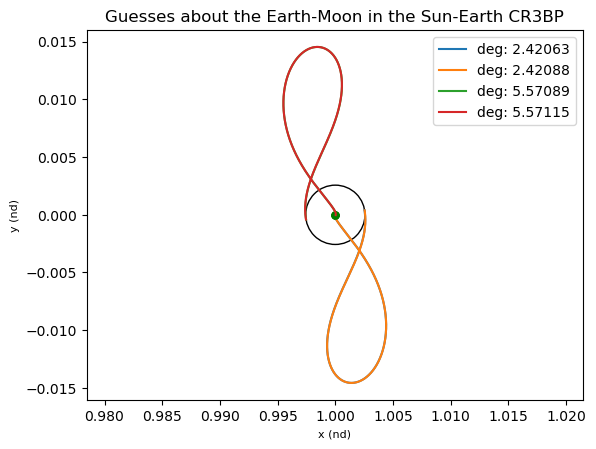

In [136]:
fig3 = plt.figure(); ax3 = plt.axes()
mu = mu_crtbp
circle4 = plt.Circle((1-mu, 0), y_f, color='k', fill=False)
ax3.add_artist(circle4)
ax3.axis('equal')
plt.title('Guesses about the Earth-Moon in the Sun-Earth CR3BP')
plt.xlabel('x (nd)', fontsize=8); plt.ylabel('y (nd)', fontsize=8)

ode_rtol = 1e-12
ode_atol = 1e-12
tau_0 = 0.0; tau_f = 1
t0 = 0.0
n_points = 5000
epoch_t0 = spice.str2et('1 June 2024 00:00:00 TDB')
reference_frame = "j2000"
mu_p = mu_bodies[id_primary]; mu_s = mu_bodies[id_secondary]
naif_id_p = naif_id_bodies[id_primary]; naif_id_s = naif_id_bodies[id_secondary]
tau_vec_input = np.linspace(tau_0, tau_f, n_points)
tau_vec, t_vec = rnbp_utils.compute_time(tau_vec_input, t0, epoch_t0, mu_p, mu_s, naif_id_p, naif_id_s, reference_frame, ode_rtol = ode_rtol, ode_atol = ode_atol)

threebody = lambda t, state : threebody_orbit(t, state, mu_crtbp)

def plot_family(npy):
    data = np.load(npy, allow_pickle=True)
    print(f'{len(data)} orbits')
    for orbit in data:
        t_vec_temp = np.linspace(0, orbit['tf'], num=3000)
        tau = orbit['tf'] * t_vec[-1]
        epoch_time = compute_epoch_time(tau, tau_vec, t_vec, epoch_t0)
        
        moon_state, _ = spice.spkgeo(id_moo[1], epoch_time, reference_frame, id_ear[1])
        
        input_dict = {
            "id_primary": id_primary,
            "id_secondary": id_secondary,
            "mu_bodies": mu_bodies,
            "naif_id_bodies": naif_id_bodies,
            "observer_id": id_ear[1],
            "reference_frame": reference_frame,
            "epoch_t0": epoch_t0
        }
        moon_state = crtbp_frame.inertialEphemerisToSynodic(epoch_time, moon_state, input_dict)[0]
        moon_xy = lambda t: np.linalg.norm(np.subtract(crtbp_frame.inertialEphemerisToSynodic(t, spice.spkgeo(id_moo[1], epoch_time, reference_frame, id_ear[1])[0], input_dict)[0][0:2], orbit['xf'][0:2]))
        end_epoch = fsolve(moon_xy, epoch_time)

        moon_state_end, _ = spice.spkgeo(id_moo[1], end_epoch, reference_frame, id_ear[1])
        moon_state_end = crtbp_frame.inertialEphemerisToSynodic(end_epoch, moon_state, input_dict)[0]
        print(f'Moon:: {moon_state_end[0:2]}')
        print(f'xf: {orbit["xf"][0:2]}')
        print(f'end time:{spice.et2utc(end_epoch, "C", 0)}')
        ax3.plot(moon_state_end[0], moon_state_end[1], 'go', markersize=5)

        x0 = [orbit['x0'][0], orbit['x0'][1], orbit['x0'][3], orbit['x0'][4]]
        sol = solve_ivp(threebody, [t_vec_temp[0], t_vec_temp[-1]], x0, t_eval=t_vec_temp, method='DOP853', rtol=ode_rtol, atol=ode_atol)
        ax3.plot(sol.y[0,:], sol.y[1,:], label=f'deg: {orbit["deg"]:.5f}')
    ax3.legend()

plot_family('threebody_guesses_3.00036.npy') # 2
#plot_family('threebody_guesses_3.00066.npy') # 3
#plot_family('threebody_guesses_3.000532.npy') # 2
#plot_family('threebody_guesses_3.000645.npy') # 1
#plot_family('threebody_guesses_3.000728.npy') # 2
#plot_family('threebody_guesses_3.000774.npy') # 3
#plot_family('threebody_guesses_3.000804.npy') # 3

In [ ]:
fig3 = plt.figure(); ax3 = plt.axes()
mu = mu_crtbp
circle4 = plt.Circle((1-mu, 0), y_f, color='k', fill=False)
ax3.add_artist(circle4)
ax3.axis('equal')
plt.title('Guesses about the Earth-Moon in the Sun-Earth CR3BP')
plt.xlabel('x (nd)', fontsize=8); plt.ylabel('y (nd)', fontsize=8)

ode_rtol = 1e-12
ode_atol = 1e-12
tau_0 = 0.0; tau_f = 1
t0 = 0.0
n_points = 5000
epoch_t0 = spice.str2et('1 June 2024 00:00:00 TDB')
reference_frame = "j2000"
mu_p = mu_bodies[id_primary]; mu_s = mu_bodies[id_secondary]
naif_id_p = naif_id_bodies[id_primary]; naif_id_s = naif_id_bodies[id_secondary]
tau_vec_input = np.linspace(tau_0, tau_f, n_points)
tau_vec, t_vec = rnbp_utils.compute_time(tau_vec_input, t0, epoch_t0, mu_p, mu_s, naif_id_p, naif_id_s, reference_frame, ode_rtol = ode_rtol, ode_atol = ode_atol)
    

t_vec_temp = np.linspace(0, orbit['tf'], num=3000)
tau = orbit['tf'] * t_vec[-1]
epoch_time = compute_epoch_time(tau, tau_vec, t_vec, epoch_t0)

moon_state, _ = spice.spkgeo(id_moo[1], epoch_time, reference_frame, observer_id)

input_dict = {
    "id_primary": id_primary,
    "id_secondary": id_secondary,
    "mu_bodies": mu_bodies,
    "naif_id_bodies": naif_id_bodies,
    "observer_id": observer_id,
    "reference_frame": reference_frame,
    "epoch_t0": epoch_t0
}
#moon_state = crtbp_frame.inertialEphemerisToSynodic(epoch_time, moon_state, input_dict)[0]
#moon_state = crtbp_frame.inertialEphemerisToSynodic(0, moon_state, input_dict)[0]
print(moon_state)
#moon_state = crtbp_frame.synodicToInertial(t_syn, state_syn, mu_crtbp, observer_primary_id = 1)
ax3.plot(-moon_state[0], -moon_state[1], 'go', markersize=5)
x0 = [orbit['x0'][0], orbit['x0'][1], orbit['x0'][3], orbit['x0'][4]]
sol = solve_ivp(threebody, [t_vec_temp[0], t_vec_temp[-1]], x0, t_eval=t_vec_temp, method='DOP853', rtol=ode_rtol, atol=ode_atol)
ax3.plot(sol.y[0,:], sol.y[1,:], label=f'deg: {orbit["deg"]:.5f}')
ax3.legend()
